In [2]:
import matplotlib.pyplot as plt
import tqdm
import numpy as np

from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.map_expansion.bitmap import BitMap
from nuscenes.can_bus.can_bus_api import NuScenesCanBus

dataroot='/data/Datasets/nuscenes'

nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)
nusc_map = NuScenesMap(dataroot=dataroot, map_name='singapore-onenorth')
nusc_can = NuScenesCanBus(dataroot=dataroot)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.495 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [89]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [93]:
scene = nusc.scene[0]
first_sample_token = scene['first_sample_token']
sample = nusc.get('sample', first_sample_token)
print(sample['token'], first_sample_token)

ca9a282c9e77460f8360f564131a8af5 ca9a282c9e77460f8360f564131a8af5


In [94]:
sample['data']

{'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
 'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
 'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
 'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
 'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
 'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
 'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
 'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
 'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
 'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
 'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
 'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'}

In [95]:
sample_data_lidar = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
sample_data_radar = nusc.get('sample_data', sample['data']['RADAR_FRONT'])

In [96]:
print(sample_data_lidar['ego_pose_token'], sample_data_radar['ego_pose_token'])

9d9bf11fb0e144c8b446d54a8a00184f 37091c75b9704e0daa829ba56dfa0906


In [97]:
nusc.get('ego_pose', sample_data_lidar['ego_pose_token'])

{'token': '9d9bf11fb0e144c8b446d54a8a00184f',
 'timestamp': 1532402927647951,
 'rotation': [0.5720320396729045,
  -0.0016977771610471074,
  0.011798001930183783,
  -0.8201446642457809],
 'translation': [411.3039349319818, 1180.8903791765097, 0.0]}

In [98]:
nusc.get('ego_pose', sample_data_radar['ego_pose_token'])

{'token': '37091c75b9704e0daa829ba56dfa0906',
 'timestamp': 1532402927664178,
 'rotation': [0.5721129977125774,
  -0.0014962022442161157,
  0.011922678049447764,
  -0.8200867813684729],
 'translation': [411.25243634487725, 1180.7511754315697, 0.0]}

/home/muyang/miniconda3/envs/nuscenes/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


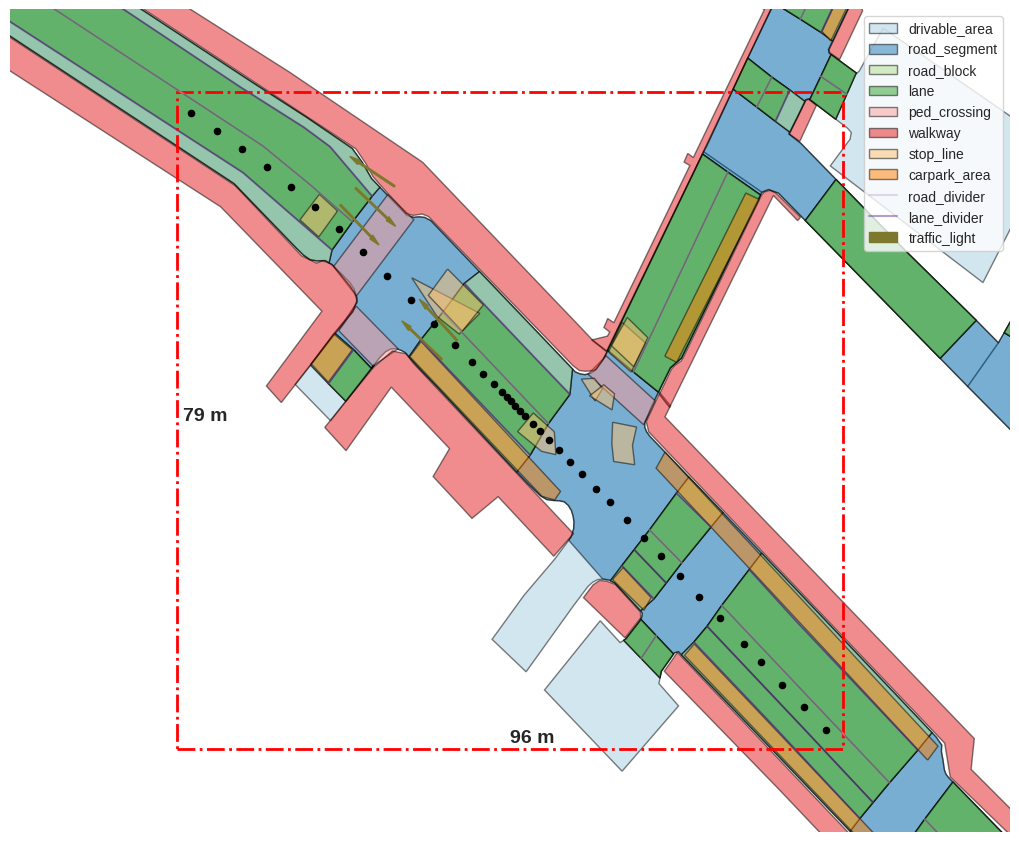

In [99]:
# Render ego poses.
nusc_map_bos = NuScenesMap(dataroot='/data/Datasets/nuscenes', map_name='boston-seaport')
ego_poses = nusc_map_bos.render_egoposes_on_fancy_map(nusc, scene_tokens=[nusc.scene[1]['token']], verbose=False)


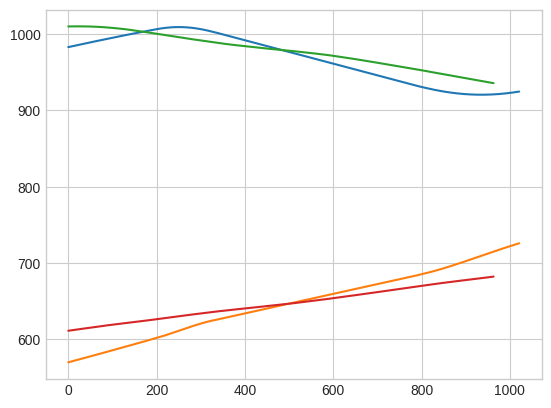

In [100]:
#final data format should be a vector over time
#iteration 1: just get the 2hz vehicle profile data
pose_route = nusc_can.get_pose_and_route('scene-0001')
plt.plot(pose_route[0])
plt.plot(pose_route[1])



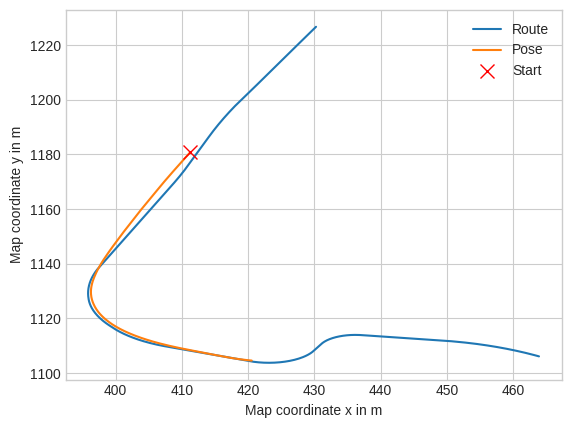

In [101]:
nusc_can.plot_baseline_route('scene-0061')

In [102]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [130]:
nusc_can.get_messages('scene-0061', 'vehicle_monitor')

[{'available_distance': 120,
  'battery_level': 91,
  'brake': 0,
  'brake_switch': 1,
  'gear_position': 7,
  'left_signal': 0,
  'rear_left_rpm': 275.2617,
  'rear_right_rpm': 276.1791,
  'right_signal': 0,
  'steering': 3.0,
  'steering_speed': 1.8118839761882555e-13,
  'throttle': 0,
  'utime': 1532402928127800,
  'vehicle_speed': 31.44,
  'yaw_rate': 0.6000000000000227},
 {'available_distance': 120,
  'battery_level': 91,
  'brake': 0,
  'brake_switch': 1,
  'gear_position': 7,
  'left_signal': 1,
  'rear_left_rpm': 267.7557,
  'rear_right_rpm': 267.7557,
  'right_signal': 0,
  'steering': 3.5,
  'steering_speed': 1.8118839761882555e-13,
  'throttle': 0,
  'utime': 1532402928627159,
  'vehicle_speed': 30.73,
  'yaw_rate': 0.6000000000000227},
 {'available_distance': 120,
  'battery_level': 91,
  'brake': 0,
  'brake_switch': 2,
  'gear_position': 7,
  'left_signal': 1,
  'rear_left_rpm': 257.2473,
  'rear_right_rpm': 256.5384,
  'right_signal': 0,
  'steering': 3.599999999999909,


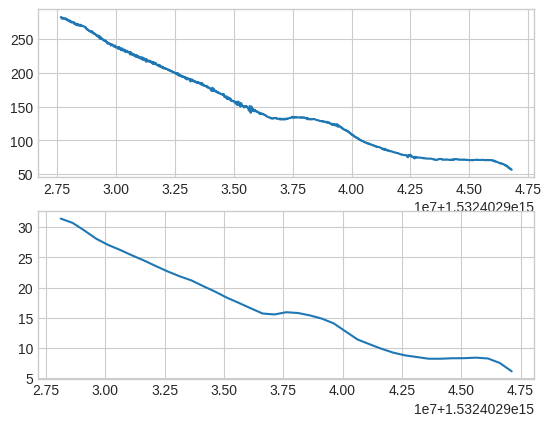

In [144]:

wheel_speed = [[i['FL_wheel_speed'], i['utime']] for i in nusc_can.get_messages('scene-0061', 'zoe_veh_info')]
y1, x1 = zip(*wheel_speed)

veh_speed = [[i['vehicle_speed'], i['utime']] for i in nusc_can.get_messages('scene-0061', 'vehicle_monitor')]
y2, x2 = zip(*veh_speed)

fig, axs = plt.subplots(2)
axs[0].plot(x1, y1)
axs[1].plot(x2, y2)

plt.show()

In [ ]:
# need some data structure to save the actions
# list of 2-tuples in format (action, start time)

In [4]:
#selecting the features we want to use from the CAN data
features = [[i['steering'], i['vehicle_speed'], i['utime']] for i in nusc_can.get_messages('scene-0061', 'vehicle_monitor')]

# actually segment actions
actions = []


for feat in features:
    steer, speed, time = feat
    if steer > 10:
        actions.append(('left', feat[2]))



# must establish a precedence of 

3.0 31.44 1532402928127800
3.5 30.73 1532402928627159
3.599999999999909 29.45 1532402929127810
3.599999999999909 28.09 1532402929627057
3.5 27.07 1532402930127656
3.599999999999909 26.25 1532402930627445
4.0 25.35 1532402931127168
4.699999999999818 24.51 1532402931627135
6.5 23.580000000000002 1532402932127384
12.599999999999909 22.69 1532402932626799
23.800000000000182 21.89 1532402933127327
34.40000000000009 21.2 1532402933627160
45.80000000000018 20.25 1532402934126855
69.80000000000018 19.34 1532402934627536
87.59999999999991 18.330000000000002 1532402935127340
90.80000000000018 17.47 1532402935627675
98.90000000000009 16.580000000000002 1532402936127003
102.0 15.71 1532402936627017
112.69999999999982 15.55 1532402937127649
117.09999999999991 15.92 1532402937627089
117.09999999999991 15.790000000000001 1532402938127018
114.90000000000009 15.39 1532402938627564
105.59999999999991 14.86 1532402939128381
102.40000000000009 14.07 1532402939627276
74.59999999999991 11.41 153240294062726

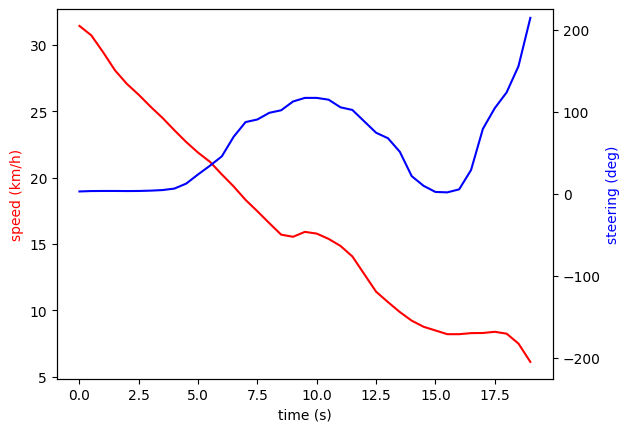

In [16]:
y2, y1, x = zip(*features)

#start at time zero, convert to seconds
x = [(i - x[0])*1e-6 for i in x]

color='red'
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (s)')
ax1.set_ylabel('speed (km/h)', color=color)
ax1.plot(x, y1, color=color)

color='blue'
ax2 = ax1.twinx()
ax2.set_ylabel('steering (deg)', color=color)
ax2.plot(x, y2, color=color)
ylim = max(ax2.get_ylim())
ax2.set_ylim(-ylim, ylim)

plt.style.use('fast')
plt.show()

In [105]:
scene_name = 'scene-0061'
steer_angle = nusc_can.get_messages(scene_name, 'steeranglefeedback')
wheel_speed = nusc_can.get_messages(scene_name, 'zoe_veh_info')
print(len(messages))
actions = []
for msg in messages:
    msg[''][0]
    if 

1899
-0.41128969192504883
-0.5330492258071899
-0.738662838935852
-0.5571042895317078
-0.7012737393379211
-0.8273831605911255
-0.7110494375228882
-0.7359715700149536
-0.7674471139907837
-0.374155730009079
-0.7169121503829956
-0.7339585423469543
-0.6623514890670776
-0.7557196617126465
-0.7842211723327637
-0.49836426973342896
-0.5673020482063293
-0.412362277507782
-0.4159470498561859
-0.6900583505630493
-0.818759560585022
-0.47662702202796936
-0.591797947883606
-0.6643785238265991
-0.6660939455032349
-0.4009881913661957
-0.5223349332809448
-0.6865041851997375
-0.6986468434333801
-0.5569115877151489
-0.45579060912132263
-0.6951096653938293
-0.662846028804779
-0.5855039358139038
-0.4009590744972229
-0.5797989964485168
-0.6279357671737671
-0.619210958480835
-0.5687904357910156
-0.5884726047515869
-0.8136428594589233
-0.6574435234069824
-0.5181750059127808
-0.724484920501709
-0.6960428357124329
-0.6335175037384033
-0.6653889417648315
-0.5709700584411621
-0.580504298210144
-0.7641634345054626
